In [1]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from preprocessing import *
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import json
import re

In [84]:
def data_sampling(dataframe, all_grades=all_grades):
    over_bench_mult = 2.2
    under_bench_mult = 1.5

    smp2 = dataframe[dataframe.Grade == 2]
    smp3 = dataframe[dataframe.Grade == 3]
    smp4 = dataframe[dataframe.Grade == 4]
    smp5 = dataframe[dataframe.Grade == 5]
    smp6 = dataframe[dataframe.Grade == 6]
    smp7 = dataframe[dataframe.Grade == 7]
    smp8 = dataframe[dataframe.Grade == 8]
    smp9 = dataframe[dataframe.Grade == 9]
    smp10 = dataframe[dataframe.Grade == 10]
   
    under_3 = pd.concat([smp3[smp3.repeats > 8], smp3[smp3.IsBenchmark == True].sample(
        frac=under_bench_mult, replace=True, random_state=1)])
    
    over_2 = smp2.sample(frac=2, replace=True, random_state=1)
    
    over_4 = pd.concat([smp4.sample(frac=1.4, replace=True), 
                    smp4[smp4.IsBenchmark == True].sample(frac=over_bench_mult, replace=True)])
    over_5 = pd.concat([smp5[smp5.IsBenchmark != True].sample(frac=1, replace=True, random_state=1), 
                     smp5[smp5.IsBenchmark == True].sample(frac=over_bench_mult, replace=True, random_state=1)])
    over_6 = pd.concat([smp6.sample(frac=1.4, replace=True, random_state=1), 
                    smp6[smp6.IsBenchmark == True].sample(frac=over_bench_mult, replace=True, random_state=1)])
    over_7 = pd.concat([smp7.sample(frac=1.6, replace=True, random_state=1), 
                    smp7[smp7.IsBenchmark == True].sample(frac=over_bench_mult, replace=True, random_state=1)])
    over_8 = pd.concat([smp8.sample(frac=1.3, replace=True, random_state=1), 
                    smp8[smp8.IsBenchmark == True].sample(frac=over_bench_mult, replace=True, random_state=1)])
    over_9 = pd.concat([smp9.sample(frac=2.1, replace=True, random_state=1), 
                    smp9[smp9.IsBenchmark == True].sample(frac=over_bench_mult, replace=True, random_state=1)])
    over_10 = pd.concat([smp10.sample(frac=2.5, replace=True, random_state=1), 
                    smp10[smp10.IsBenchmark == True].sample(frac=over_bench_mult, replace=True, random_state=1)])
    
    return pd.concat([over_2, under_3, over_4, over_5, over_6, over_7, over_8, over_9, over_10]).sample(frac = 1)

In [35]:
def split_train_test_val(df, train_size, test_size, val_size):
    # train is now 80% of the entire data set, test is now 20% of the dataset
    # X_train and X_test are DataFrames of routes, y_train and y_test are numpy arrays of grades
    train_df, test_df = train_test_split(df, train_size=train_size, stratify=df[['Grade']], shuffle=True)
    
    # test is now 10% of the initial data set
    # validation is now 10% of the initial data set
    # X_val and X_test are DataFrames of routes, y_val and y_test are numpy arrays of grades
    val_df, test_df = train_test_split(test_df, test_size=(test_size / (test_size + val_size)), stratify=test_df[['Grade']], shuffle=True) 
    
    print("X train, test, val (before sampling): ", len(train_df), len(val_df), len(test_df))
    print("y train, test, val (before sampling): ", len(train_df), len(val_df), len(test_df))
    
    # over and undersample the datasets without bleed between train, test, and validation sets
    train_df = data_sampling(train_df)
    # NOTE: the oversamping method appears to cause the datasets to be slightly different sizes each time
    # this is assumed to be due to the stratification
    
    print("X train, test, val (after sampling): ", len(train_df), len(val_df), len(test_df))
    print("y train, test, val (after sampling): ", len(train_df), len(val_df), len(test_df))

    
    return (np.array(train_df.TokenizedSequence.to_list()), 
            np.array(test_df.TokenizedSequence.to_list()), 
            np.array(val_df.TokenizedSequence.to_list()), 
            train_df.Grade.to_numpy()-df.Grade.min(),
            test_df.Grade.to_numpy()-df.Grade.min(),
            val_df.Grade.to_numpy()-df.Grade.min())

In [44]:
routes = pd.read_json('./data/route_data.json')
routes = routes[routes.MoonBoardHoldSetup == 'MoonBoard Masters 2017']

<AxesSubplot:xlabel='Grade', ylabel='count'>

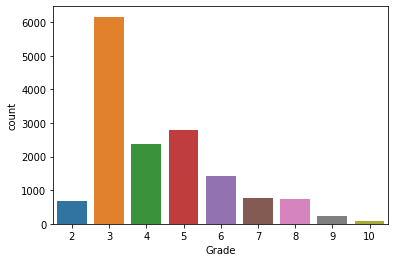

In [79]:
import re
df = routes.copy()
for i in range(11, 15):
    df = df[df.Grade != i]
df = df[df.RepeatText != 'Be the first to repeat this problem']

repeat_col = np.array([re.findall(r'\d+', x) for x in np.array(df.RepeatText)])
repeat_col.reshape(np.shape(repeat_col)[0])
df.insert(10, 'repeats', repeat_col.astype('int16'))
df.drop('RepeatText', axis=1, inplace=True)

df = df[df.repeats > 2]

sns.countplot(x='Grade', data=df)

In [80]:
route_sequences = df.apply(generate_route_sequence, axis=1)
df['TokenizedSequence'] = route_sequences.map(tokenize_sequence)

In [81]:
train_size = 0.8
test_size = 0.1
val_size = 0.1
assert train_size + test_size + val_size == 1

In [82]:
X_train, X_test, X_val, y_train, y_test, y_val = split_train_test_val(df, train_size, test_size, val_size)

X train, test, val (before sampling):  12254 1532 1532
y train, test, val (before sampling):  12254 1532 1532
X train, test, val (after sampling):  13510 1532 1532
y train, test, val (after sampling):  13510 1532 1532


<AxesSubplot:xlabel='Grade', ylabel='count'>

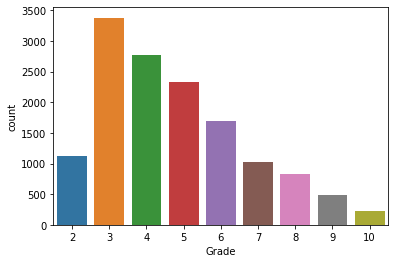

In [85]:
sns.countplot(x='Grade', data=data_sampling(df).sample(frac=0.8))

In [86]:
X_train

array([[13,  5,  6, ...,  0,  0,  0],
       [16,  5,  6, ...,  0,  0,  0],
       [14,  5,  6, ...,  0,  0,  0],
       ...,
       [10,  4,  6, ...,  0,  0,  0],
       [12,  5,  6, ...,  0,  0,  0],
       [14,  5,  6, ...,  0,  0,  0]])

In [87]:
X_test.shape

(1532, 22)

In [88]:
X_val.shape

(1532, 22)

In [89]:
train_data = {'X': X_train, 'y': y_train}
test_data = {'X': X_test, 'y': y_test}
val_data = {'X': X_val, 'y': y_val}

In [90]:
for data, split in zip([train_data, test_data, val_data], ['train', 'test', 'val']):
    with open(f'./data/{split}_cleaned_routes', 'wb') as f:
        pickle.dump(data, f)